# Deep Learning(CNN) for Detecting Malaria from Human Cell Images

![alt text](https://cdn.pixabay.com/photo/2015/10/31/21/10/mosquito-1016254_960_720.jpg)


### Objectives

- Develop a Convolutional Neural Network model for detecting whether a cell is Parasitized or not with malaria using microscopic images. 
- Deploy the model in a web app.


Author: Luis F. Salazar Salinas  Date: 15/04/2022 

### **Malaria Dataset**

The malaria dataset contain two folders:
  - Parasitized 
  - Unifected

With a total of 27,560 images

This dataset was taken from NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [ ]:
## Install wget librery
!pip install wget

In [ ]:
## Import libraries
import os 
import zipfile
import wget
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.layers import Activation,Dropout, Add
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### **Download and Extract the Dataset**

- Descomprime the zipfile 
- Create train, validation and test folders
- Split and assign the data into train, val and  test folders (80:10:10)

In [ ]:
url = 'https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip'
wget.download(url, '/tmp')

'/tmp/cell_images.zip'

In [ ]:
## Load and extract the dataset
input_path = "/tmp/cell_images.zip"

local_zip = input_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
extrac_path = '/tmp/'

for set_ in ['cell_images']:
    n_paras = len(os.listdir(extrac_path+set_ + '/Parasitized'))
    n_uninfe = len(os.listdir(extrac_path+set_ + '/Uninfected'))
    print(f"Parasitized images:{n_paras}, Uninfected images: {n_uninfe}")

Parasitized images:13780, Uninfected images: 13780


In [ ]:
##Create train, val and test files
try:
    os.mkdir('/tmp/malaria_Disease')
    os.mkdir('/tmp/malaria_Disease/train')
    os.mkdir('/tmp/malaria_Disease/train/Uninfected')
    os.mkdir('/tmp/malaria_Disease/train/Parasitized')
    
     
    os.mkdir('/tmp/malaria_Disease/val')
    os.mkdir('/tmp/malaria_Disease/val/Uninfected')
    os.mkdir('/tmp/malaria_Disease/val/Parasitized')
    

    os.mkdir('/tmp/malaria_Disease/test')
    os.mkdir('/tmp/malaria_Disease/test/Uninfected')
    os.mkdir('/tmp/malaria_Disease/test/Parasitized')
    
    
except OSError as file:
  print(file)

In [ ]:
#Split and assign the data into train, val and test files(80:10:10)
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, VAL, TESTING):
    
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name
        
        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point_1 = int(n_files * 0.8)
    split_point_2 = int(n_files * 0.9)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point_1]
    val_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in val_set:
        copyfile(SOURCE + file_name, VAL + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

uninfe_SOURCE_DIR = '/tmp/cell_images/Uninfected/'
parasi_SOURCE_DIR = '/tmp/cell_images/Parasitized/'

TRAINING_uninfe_DIR ='/tmp/malaria_Disease/train/Uninfected/'
TRAINING_parasi_DIR = '/tmp/malaria_Disease/train/Parasitized/'

VAL_uninfe_DIR ='/tmp/malaria_Disease/val/Uninfected/'
VAL_parasi_DIR = '/tmp/malaria_Disease/val/Parasitized/'

TESTING_uninfe_DIR ='/tmp/malaria_Disease/test/Uninfected/'
TESTING_parasi_DIR ='/tmp/malaria_Disease/test/Parasitized/'

split_data(uninfe_SOURCE_DIR, TRAINING_uninfe_DIR, VAL_uninfe_DIR,TESTING_uninfe_DIR)
split_data(parasi_SOURCE_DIR, TRAINING_parasi_DIR, VAL_parasi_DIR,TESTING_parasi_DIR)

In [ ]:
## Total data into Train, Val and Test folders
path_file = "/tmp/malaria_Disease/"

for tn in ['train']:
  tr = len(os.listdir(path_file+tn+'/Parasitized')) + len(os.listdir(path_file + tn+'/Uninfected'))
  print(f"train set: {tr}")
  for v in['val']:
    vl = len(os.listdir(path_file+v+'/Parasitized')) + len(os.listdir(path_file + v +'/Uninfected'))
    print(f"Validation set: {vl}")
    for ts in ['test']:
      tt = len(os.listdir(path_file+ ts +'/Parasitized')) + len(os.listdir(path_file + ts +'/Uninfected'))
      print(f"Test set: {tt}")

train set: 22048
Validation set: 2756
Test set: 2756


### **Explore the data**
- Display some images from Malaria dataset

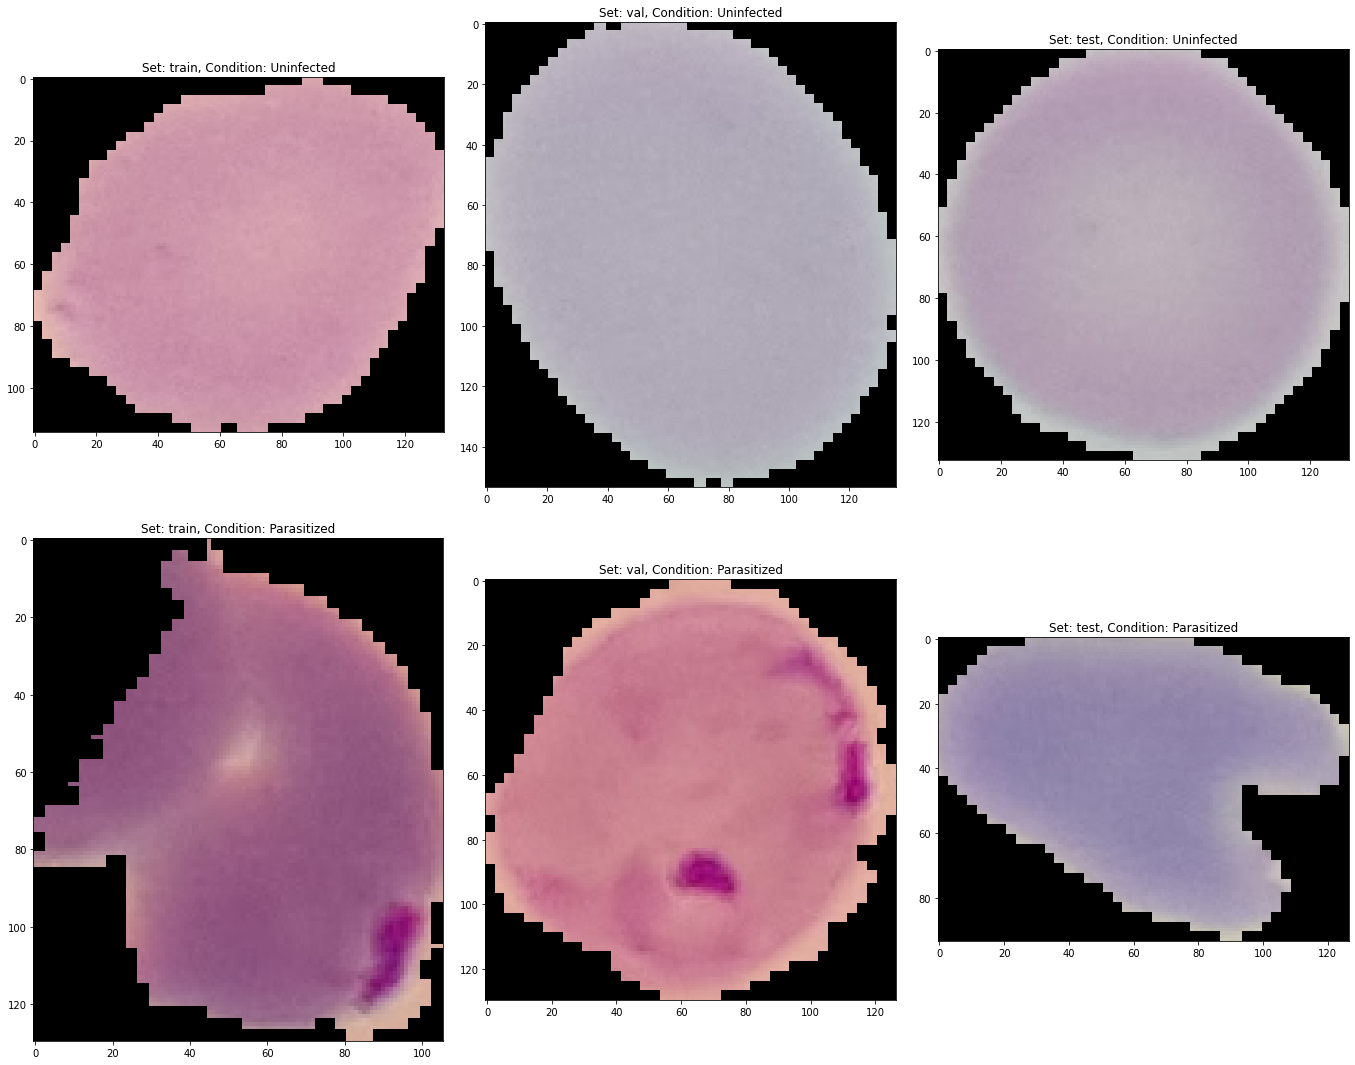

In [ ]:
## Diplay some images
path  = '/tmp/malaria_Disease/'

fig, ax = plt.subplots(2,3,figsize=(19,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val','test']):
    set_path = path + set_
    ax[i].imshow(plt.imread(set_path+'/Uninfected/'+os.listdir(set_path+'/Uninfected')[0]))
    ax[i].set_title('Set: {}, Condition: Uninfected'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Parasitized/'+os.listdir(set_path+'/Parasitized')[0]))
    ax[i+3].set_title('Set: {}, Condition: Parasitized'.format(set_))

#### **Training Distribution Strategy**
- One Divice Strategy

In [ ]:
## Choose a device type (CPU or GPU)
devices = tf.config.list_physical_devices('GPU')
print(devices[0])

## Name divice
name_gpu = "GPU:0"

## Define my strategy like One Device Strategy 
one_d_strategy = tf.distribute.OneDeviceStrategy(device=name_gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### **Data preprocessing**
- Split data into train and test set
- Data normalization[0,1]
- Data augmentation using saveral techniques such as:
  - image flipping
  - zoom
  - image rotation
  - Image brightness range


Note: the techniques of data augmentation were implemented using ImageDataGenerator from Keras.

In [ ]:
## Vertical split
def data_gen(img_dims, batch_size):
  
  ## Training data
  train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       rotation_range = 40, 
                                       zoom_range = 0.1, 
                                       horizontal_flip = True,
                                       vertical_flip=True,
                                       brightness_range=[0.5, 0.7],
                                       fill_mode = 'nearest',
                                   )
        
    
  ## Train generator
  train_gen = train_datagen.flow_from_directory(directory = path + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True)
  ## Validation Data
    
  validation_datagen = ImageDataGenerator(rescale = 1./255)
  ## validation generator
    
  val_gen = validation_datagen.flow_from_directory(directory = path + 'val',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                                                      class_mode = 'binary',
                                                      shuffle = True)
  
    
  return train_gen, val_gen 

In [ ]:
img_dims = 150
batch_size = 128

train_gen, val_gen = data_gen(img_dims, batch_size)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


### **Modeling**
- CNN model 
- Training:
 - Epochs = 100
 - Nadam optimizer with a 0.001 base learning rate
- Model performance with the train and validation set
 - Loss and accuracy plots
- Model (the best model) performance with the test set 
   - Metrics:
    - Confusion matrix
    - Accuracy Score
    - ROC-AUC Score

###### **CNN model architecture**

In [ ]:
def malaria_model():
    
    inp = Input(shape=(img_dims, img_dims, 3), name='input')
    
    # Conv Block 1
    x = Conv2D(filters = 64,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 64,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    # Conv Block 2
    x = Conv2D(filters = 128,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 128,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    
    # Conv Block 3
    x = Conv2D(filters = 255,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 255,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)

    # Conv Block 4
    x = Conv2D(filters = 512,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 512,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 512,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)

    # Conv Block 5
    x = Conv2D(filters = 512,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 512,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 512,kernel_size =(3,3), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 4096, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(units = 4096, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = Dropout(0.5)(x)
    
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs = inp, outputs = pred )

     ## Display summary
    model.summary()

    ## Model compile
    model.compile(optimizer = Nadam(learning_rate = lr_schedule(0)),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    return model

###### **Training the Model**
- Callbacks
 - Learningratescheduler
 - EarlyStopping
- Compile the model under the strategy scope
- Model fit


In [ ]:
## Callbacks
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
## Setting lr for different number of epochs
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 10:
    lr *= 1e-1
  elif epoch > 20:
    lr *= 1e-2
  elif epoch > 30:
    lr *= 1e-3
  print("Learning rate:", lr) 
  return lr
## Callbacks
schedule = LearningRateScheduler(lr_schedule)
earlystopping = EarlyStopping(monitor = "val_loss", patience = 20, mode ='min')

In [ ]:
## Compile the model under the strategy scope
with one_d_strategy.scope():
  model = malaria_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 150, 150, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 64)     256       
 hNormalization)                                             

In [ ]:
## Train the model
hist = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    epochs = 40,
    validation_data = val_gen,
    validation_steps = val_gen.samples // batch_size,
    verbose = 'auto',
    callbacks = [schedule, earlystopping] 
)

Learning rate: 0.001
Epoch 1/40
172/172 [==============================] - 353s 2s/step - loss: 0.5862 - accuracy: 0.8702 - val_loss: 0.3935 - val_accuracy: 0.9014 - lr: 0.0010
Learning rate: 0.001
Epoch 2/40
172/172 [==============================] - 319s 2s/step - loss: 0.1601 - accuracy: 0.9509 - val_loss: 0.2104 - val_accuracy: 0.9501 - lr: 0.0010
Learning rate: 0.001
Epoch 3/40
172/172 [==============================] - 319s 2s/step - loss: 0.1476 - accuracy: 0.9539 - val_loss: 0.1611 - val_accuracy: 0.9583 - lr: 0.0010
Learning rate: 0.001
Epoch 4/40
172/172 [==============================] - 319s 2s/step - loss: 0.1417 - accuracy: 0.9552 - val_loss: 0.1754 - val_accuracy: 0.9446 - lr: 0.0010
Learning rate: 0.001
Epoch 5/40
172/172 [==============================] - 320s 2s/step - loss: 0.1383 - accuracy: 0.9562 - val_loss: 0.1946 - val_accuracy: 0.9334 - lr: 0.0010
Learning rate: 0.001
Epoch 6/40
172/172 [==============================] - 319s 2s/step - loss: 0.1376 - accuracy: 

##### **Model performance with the train and validation.**
- Loss and accuracy plots
- Validation Metrics:
  - Accuracy

loss: 0.11114386469125748
accuracy: 0.9611756205558777


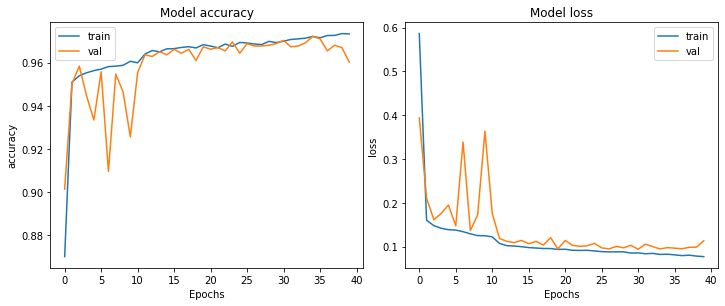

In [ ]:
## PLOTS
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax.ravel()
plt.tight_layout()

for i, m in enumerate(['accuracy', 'loss']):
  ax[i].plot(hist.history[m])
  ax[i].plot(hist.history['val_'+ m])
  ax[i].set_title(f"Model {m}")
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel(m)
  ax[i].legend(['train','val' ])

## Model evaluation
result_eval_ = model.evaluate(val_gen, verbose = 0)
for metric, val in zip(model.metrics_names, result_eval_):
  print(metric + f': {val}')

##### **Observations.**

- According to the loss and accuracy plots, we can see that the model is converging because the loss and loss validation functions are decreasing along with each epoch.

- The model was able to reach 96% validation accuracy in 40 epochs.

#### **Save the model.**


In [ ]:
model.save('malaria_model', save_format='h5')